In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import shapely
from shapely.geometry import mapping
import earthpy as et
import earthpy.plot as ep
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import georasters as gr
import mapclassify as mpc
import rasterio
from osgeo import gdal
from matplotlib_scalebar.scalebar import ScaleBar
import pyproj
from pyproj import CRS
from pyproj import Transformer
import fiona

ModuleNotFoundError: No module named 'shapely'

In [1]:
def population_density(population_raster_file,country_file,administrative_file,metric_projection_name):
    
#country file, might need to be changed 
    KOR = os.path.join(country_file, administrative_file)
    kor = gpd.read_file(KOR)
    wpgt_r = rasterio.open(population_raster_file,masked=True)
    wpgt_r.bounds

    #cropping the ratser to Kor, and getting population data
    temp1=kor["geometry"]
    population_sum_Kor=[]
    for row in temp1:
        if row.geom_type=='Polygon':
            gtraster1, bound1 = rasterio.mask.mask(wpgt_r, [row], crop=True)
        else: 
            gtraster1, bound1 = rasterio.mask.mask(wpgt_r, row , crop=True)
        population_sum_Kor+=[gtraster1[gtraster1>0].sum()]

    
    ##
    matches=[]
    projection=[['esri:102022', 'Africa_Albers_Equal_Area_Conic'],
    ['esri:102008', 'North America Albers Equal Area Conic'],
    ['esri:102013', 'Europe_Albers_Equal_Area_Conic'],
    ['esri:102025', 'Asia_North_Albers_Equal_Area_Conic'],
    ['esri:102028', 'Asia_South_Albers_Equal_Area Conic'],
    ['esri:102033', 'South_America_Albers_Equal_Area_Conic']]
    for match in projection :
        if metric_projection_name in match:
            matches.append(match)

    proj=matches[0][0]

    area1=kor['geometry'].to_crs(proj)\
               .map(lambda p: p.area / 10**6)
    density1 = population_sum_Kor/area1
    answer1 = kor
    answer1["population_density_km2"] = density1
    answer1["logpop"]=np.log10(density1)

    admlabel=[]
    x = administrative_file.split("_")
    z=x[1].split(".")
    adminL=[['adm1' ,'Provence administrative level'],['adm2','District administrative level']]

    for y in adminL :
        if z[0] in y:
            admlabel.append(y)

       
    kor= kor.to_crs(proj)
    answer1=answer1.to_crs(proj)
    fig, ax = plt.subplots(figsize = (15,15))
    answer1.plot(ax=ax)
    kor.plot(categorical=True, edgecolor='black', color = 'none', marker='*', legend=True, markersize=50, cmap='Set2', ax=ax)
    answer1.plot(column='population_density_km2',categorical=False, cmap="OrRd", figsize=(10, 10), ax=ax,legend=True, legend_kwds={'label':'Population in log scale '+ admlabel[0][1] },norm=matplotlib.colors.LogNorm(vmin=answer1['population_density_km2'].min(), vmax=answer1['population_density_km2'].max()))
    ax.set_title('S.Korea '+admlabel[0][1])
    ax.add_artist(ScaleBar(1))
    plt.show()
    #fig.savefig('population_density.jpg', format='jpg', dpi=300, bbox_inches='tight', pad_inches=0.05)

/Users/priya/opt/anaconda3/envs/geopandas/lib/python3.9/site-packages/rasterio/features.py:447: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape) for shape in shapes]
/Users/priya/opt/anaconda3/envs/geopandas/lib/python3.9/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


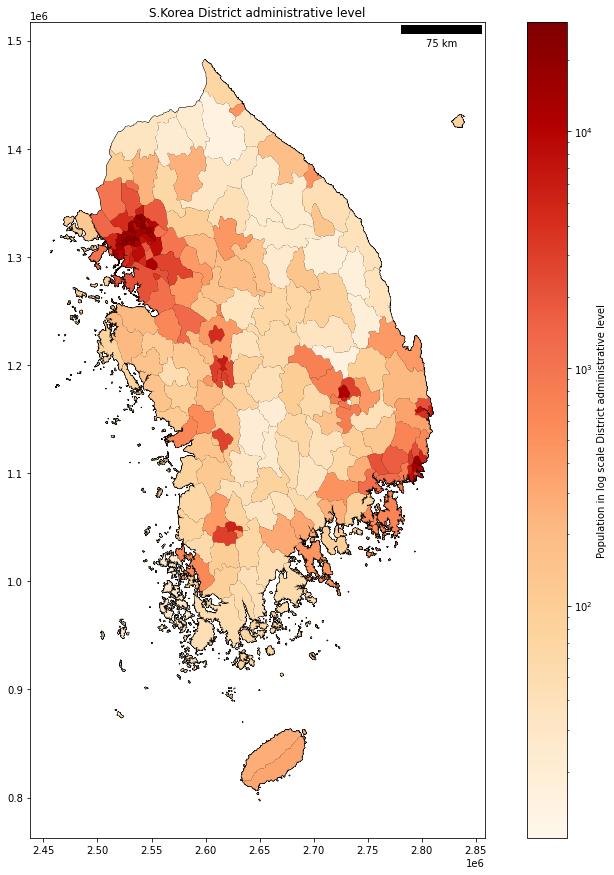

In [3]:
population_density("kor_ppp_2020_UNadj_constrained.tiff","KOR_adm","KOR_adm2.shp",'Asia_North_Albers_Equal_Area_Conic')